# Optimal $\delta$, $\beta$ separatly and together

### Algorithm:
1. initial guess of the vaccination rate;
2. slove the state system with the initial vaccination rate;
3. obtain the vaccination rate with the solution of step 2;
4. obtian the total cost;
5. repeat step 2, 3 and 4 until the total cost can converge. 

#### Solution of the state system
##### input:
1. vaccination rate;
2. Metapopulation information: population, contact rate, etc.;
3. transportation data;
4. epidemical model and data. 
##### output:
1. epidemical data;
2. $\lambda_j^S$ and $\lambda_j^V$.

#### Solution of the adjoint system
##### input:
1. output of the state system solution;
2. $\mu_{S,j}(T)=\mu_{V,j}(T)=\mu_{L,j}(T)=\mu_{I,j}(T)=\mu_{R,j}(T)=0$.
##### output:
1. adjusted vaccination rate $\beta^*$ and transport rate $\delta^*$;
2. total cost.

In [1]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
import time
import pickle
%load_ext autoreload
%autoreload 2


### Load Data

In [2]:
commute_path = 'V_data/Commute.csv'
covid_path = 'V_data/Covid.csv'
travel_path = 'V_data/Transport_data.csv'
kpa_path = 'V_data/Kpa_rate.csv'
#bed_path = '/Users/liuyang/Data/Input_data3/region_bed_count.csv'

In [3]:
name_path = 'V_data/Region_code.csv'
name = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(name_path, newline='') as name_f:
    name_reader = csv.reader(name_f, delimiter= ' ', quotechar='|')
    next(name_reader, None)
    for row in name_reader:
        #print(row)
        (code, reg)=row[0].split(',')
        #print(dep, arr)
        name[int(code) ] = reg

In [4]:
sigma = {} #the dict to store the commuting rate data, {(residence, work): commute rate}
with open(commute_path, newline='') as com_f:
    com_reader = csv.reader(com_f, delimiter= ' ', quotechar='|')
    next(com_reader, None)
    for row in com_reader:
        (res, wor, rate)=row[0].split(',')
        sigma[(int(res), int(wor))] = float(rate)
for i in sigma:
    if i[0]==i[1]:
        sigma[i]=0

In [5]:
N_p = {} #the dict to store population data {area code: population}
N_0 = {}  # the dict to store the initial health state data {area code: [S,V, L, I_a, I_t, I_nt, R]}
with open(covid_path, newline='') as covid_f:
    covid_reader = csv.reader(covid_f, delimiter= ' ', quotechar='|')
    next(covid_reader, None)
    for row in covid_reader:
        (code, t_pop, S, V, L, I, R)=row[0].split(',')
        N_p[int(code)] = int(t_pop)
        N_0[int(code)]= [float(S),float(V), float(L),float(I),float(R)]

In [6]:
X = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(travel_path, newline='') as travel_f:
    travel_reader = csv.reader(travel_f, delimiter= ' ', quotechar='|')
    next(travel_reader, None)
    for row in travel_reader:
        (dep, arr, pcnt)=row[0].split(',')
        #print(dep, arr)
        X[(int(dep), int(arr))] = float(pcnt)*1000/365

In [7]:
kpa = {} # the dict to store the infection rate for different areas {area code: infection rate}
with open(kpa_path, newline='') as kpa_f:
    kpa_reader = csv.reader(kpa_f, delimiter= ' ', quotechar='|')
    next(kpa_reader, None)
    for row in kpa_reader:
        (code, kpa_j)=row[0].split(',')
        kpa[int(code)] = float(kpa_j)

In [8]:
vac_cnt_path = 'V_data/Vaccine_cnt.csv'

Vac_cnt = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(vac_cnt_path, newline='') as vac_cnt_f:
    vac_cnt_reader = csv.reader(vac_cnt_f, delimiter= ' ', quotechar='|')
    next(vac_cnt_reader, None)
    for row in vac_cnt_reader:
        list_vc=row[0].split(',')
        Vac_cnt[int(list_vc[0])] = [int(n)/7 for n in list_vc[1:]]

In [9]:
# actural vaccination rate by prefectures
with open('V_data/Beta_act.pkl', 'rb') as f:
    beta_a = pickle.load(f)
#actural transportation rate in country wide range from docomo data
with open('V_data/Tsp_rate.pkl', 'rb') as f:
    delta_a = pickle.load(f)
# actural vaccination data in Japan
with open('V_data/C_Beta_act.pkl', 'rb') as f:
    C_beta = pickle.load(f)

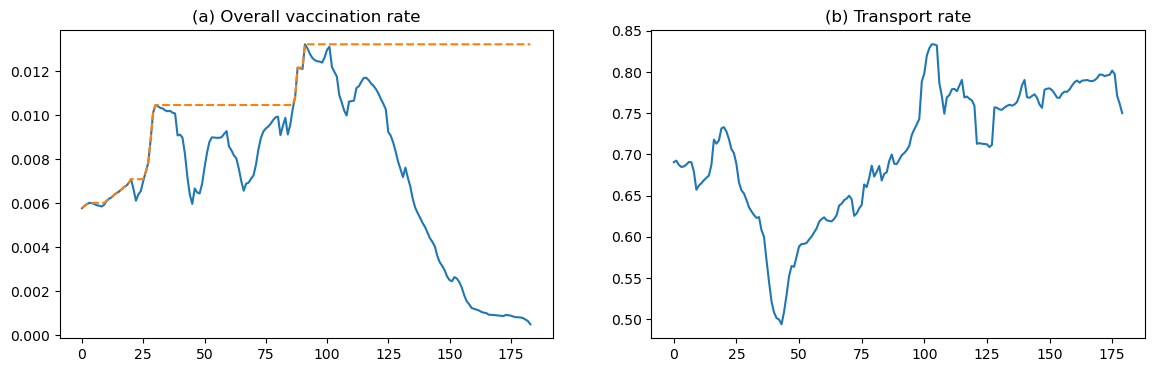

In [11]:
# calculate the maximum to-date vaccination rate 
beta_c_max = [max(C_beta[:t]) for t in range(1,len(C_beta)+1)] # c denotes for country

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(C_beta)
plt.plot(beta_c_max, linestyle='--')
plt.title('(a) Overall vaccination rate')

plt.subplot(1,2,2)
plt.plot(delta_a)
plt.title('(b) Transport rate')
plt.show()

### Parameters

In [12]:
Z = {0: list(range(1, 48))}

In [13]:

#p_a = 0.0025          # probability of asymptomatic patients
p_t = 1
v = 1/7               # infection period
xi = 1/1.1            # latent period
tau = 3               # return rate of daily commuters
#r = 1                # ratio of infectiousness of asymptomatic person
eta = 3               # coefficient to change the daily contact
t_s = 1.8             # period of stay of tourists
gamma_s = 0.007       # infection rate of unvaccinated individuals
gamma_v =0.0002       # infection rate of vaccinated individuals
t_f = {(0,0): 0.5}
T = 180


In [15]:
from Adjoint_system import *
from State_system import *

In [14]:
c_b_hat = 100000
#c_b = {j:1500000+(N_p[j]/1000)**0.5*c_b_hat for j in N_p}
#print(c_b)

beta_max = beta_c_max
del_min = 0.5
beta_min = 0.001
c_i = {j:2 for j in N_0} # infection cost
c_v = 0.0413 # purchase cost
c_d = 500260 # transport control loss

In [15]:
V_sum = sum(Vac_cnt[0])

In [16]:
# Japanese government cost on vaccination, convert to K dollars for half year
V_c =1.2954*1000000000000/120/1000/2
T_p = sum(N_p[j] for j in N_p)
C_pre = {j: V_c*N_p[j]/T_p/sum(beta_a[j][t]**2 for t in range(len(beta_a[j]))) for j in N_p}
print(C_pre)

{1: 22165534.33403992, 2: 4587892.551386056, 3: 4835606.823534076, 4: 8400318.759694947, 5: 3477429.531214999, 6: 4612923.375044096, 7: 7307381.335894105, 8: 8381411.747123657, 9: 5962222.933597219, 10: 6546785.864731077, 11: 19791837.413629305, 12: 17522125.176550966, 13: 36087346.93145529, 14: 24353099.92913127, 15: 8343921.718545619, 16: 3223131.226584779, 17: 4761131.753162852, 18: 2983591.539598895, 19: 2778546.0472881785, 20: 7491575.423913272, 21: 7157482.362883456, 22: 9441328.89473051, 23: 25765074.252924085, 24: 6559460.799366409, 25: 4482526.408181289, 26: 11801787.41583872, 27: 34494359.813429266, 28: 20529126.07850707, 29: 4908912.280379709, 30: 4596429.9620830985, 31: 2920272.642761536, 32: 3103524.4881142857, 33: 10319098.189024588, 34: 11931006.205919672, 35: 6489200.063694972, 36: 3381374.8277512463, 37: 4290820.565737481, 38: 5938956.018232653, 39: 3801534.084953701, 40: 20754032.491190497, 41: 4351676.598183717, 42: 5658634.091427798, 43: 7148924.064440193, 44: 55579

In [17]:
c_b = C_pre

### Optimize both $\delta$ and $\beta$

In [18]:
### optimize both delta and beta

beta_b = beta_a # optimize both
delta_b = delta_a # optimize both
n = 0
l_cost = 1e10
T = 180
tol = [10]
cost_sum = {}
#R_inf = {}
params = {'p_t':p_t, 'v':v, 'xi':xi, 'tau':tau, 'eta':eta, 't_s':t_s, 
          'gamma_s':gamma_s, 'gamma_v':gamma_v,  
          'c_v':c_v, 'c_i':c_i , 'c_b':c_b, 'c_d':c_d, 't_f':t_f, 'T':T}
while tol[-1] >= 1e-6: 
    s_z = 0.5/(n+1)**0.5
    b_star = beta_b
    d_star = delta_b
    Vac_res = State_solution(N_p, N_0, sigma, X, kpa, Z, d_star, b_star, params)
    R_inf, cost_sum[n], L_s, L_v = Vac_res.get_res()
    Adj_sys = Adjoint_solution(L_s, L_v, X,kpa,  N_p, sigma, R_inf, beta_max, beta_min, del_min, b_star, d_star, params)
    beta_new = Adj_sys.get_beta()
    delta_new = Adj_sys.get_delta()
    beta_b = {j: [(1-s_z)*b_star[j][t] + s_z*beta_new[j][t] for t in range(len(beta_new[j]))] for j in beta_new}
    delta_b = [(1-s_z)*d_star[i] + s_z*delta_new[i] for i in range(len(delta_new))]
    s_cost = cost_sum[n]
    tol.append(abs(l_cost-s_cost)/l_cost)
    l_cost = s_cost
    print('round', n, ':', s_cost, tol[-1])
    n += 1

round 0 : 57059096.485943526 0.9942940903514057
round 1 : 45372226.43618317 0.2048204540469618
round 2 : 42498756.45377799 0.06333103327972596
round 3 : 41249710.281343736 0.029390181658438142
round 4 : 40573348.99166755 0.016396752487788782
round 5 : 40162289.02364914 0.010131280218027445
round 6 : 39892618.042409755 0.006714532159274911
round 7 : 39705985.24776688 0.004678379204003713
round 8 : 39571569.58896795 0.0033852744859540476
round 9 : 39471846.744861364 0.0025200628921827313
round 10 : 39395957.06708563 0.001922628000312979
round 11 : 39337008.142466076 0.0014963191405446493
round 12 : 39290443.6730608 0.0011837318495762801
round 13 : 39253121.64591353 0.000949900883223172
round 14 : 39222831.494891204 0.0007716622207924667
round 15 : 39197980.471656896 0.0006335856511925873
round 16 : 39177412.43354773 0.0005247218826500681
round 17 : 39160258.14152954 0.0004378617921050028
round 18 : 39145841.203415774 0.00036815227472861665
round 19 : 39133641.36960061 0.00031165082777938

In [153]:
### optimize only beta OV

beta_o = beta_a 
delta = delta_a # delta does not change in each iteration
n = 0
l_cost = 1e10
T = 180
tol = [10]
cost_b = {}
#R_inf = {}
params = {'p_t':p_t, 'v':v, 'xi':xi, 'tau':tau, 'eta':eta, 't_s':t_s, 
          'gamma_s':gamma_s, 'gamma_v':gamma_v,  
          'c_v':c_v, 'c_i':c_i , 'c_b':c_b, 'c_d':c_d, 't_f':t_f, 'T':T}
while tol[-1] >= 1e-6: 
    s_z = 0.5/(n+1)**0.5
    b_star = beta_o
    d_star = delta
    Vac_res = State_solution(N_p, N_0, sigma, X, kpa, Z, d_star, b_star, params)
    R_inf_b, cost_b[n], L_s, L_v = Vac_res.get_res()
    Adj_sys = Adjoint_solution(L_s, L_v, X,kpa,  N_p, sigma, R_inf_b, beta_max, beta_min, del_min, b_star, d_star, params)
    beta_new = Adj_sys.get_beta()
    #delta_new = Adj_sys.get_delta()
    beta_o = {j: [(1-s_z)*b_star[j][t] + s_z*beta_new[j][t] for t in range(len(beta_new[j]))] for j in beta_new}
    #delta = [(1-s_z)*d_star[i] + s_z*delta_new[i] for i in range(len(delta_new))]
    s_cost = cost_b[n]
    tol.append(abs(l_cost-s_cost)/l_cost)
    l_cost = s_cost
    print('round', n, ':', s_cost, tol[-1])
    n += 1

round 0 : 57059096.485943526 0.9942940903514057
round 1 : 50919848.437556155 0.10759455418120353
round 2 : 49223774.9405647 0.033308690992499286
round 3 : 48426543.28374649 0.016196069029261354
round 4 : 47969167.76971 0.009444727684909972
round 5 : 47676726.34611855 0.006096445637652092
round 6 : 47476402.211957894 0.004201717473350843
round 7 : 47332448.34783563 0.003032114006440159
round 8 : 47225285.74083919 0.0022640410698581497
round 9 : 47143316.74444779 0.001735701438446058
round 10 : 47079252.346568406 0.001358928524835485
round 11 : 47028294.51373476 0.0010823840714063939
round 12 : 46987165.22385498 0.0008745647764829023
round 13 : 46953555.71212941 0.0007152913261622234
round 14 : 46925797.898073174 0.0005911759745399209
round 15 : 46902660.33654878 0.0004930669815065889
round 16 : 46883216.935748555 0.0004145479309854178
round 17 : 46866759.97290304 0.00035102034205684515
round 18 : 46852740.93161416 0.00029912546327051165
round 19 : 46840729.35774922 0.0002563686483672068

In [154]:
### optimize only delta OT

beta = beta_a # beta does not change in each iteration
delta_o = delta_a
n = 0
l_cost = 1e10
T = 180
tol = [10]
cost_d = {}
#R_inf = {}
params = {'p_t':p_t, 'v':v, 'xi':xi, 'tau':tau, 'eta':eta, 't_s':t_s, 
          'gamma_s':gamma_s, 'gamma_v':gamma_v,  
          'c_v':c_v, 'c_i':c_i , 'c_b':c_b, 'c_d':c_d, 't_f':t_f, 'T':T}
while tol[-1] >= 1e-6: 
    s_z = 0.5/(n+1)**0.5
    b_star = beta
    d_star = delta_o
    Vac_res = State_solution(N_p, N_0, sigma, X, kpa, Z, d_star, b_star, params)
    R_inf_d, cost_d[n], L_s, L_v = Vac_res.get_res()
    Adj_sys = Adjoint_solution(L_s, L_v, X,kpa,  N_p, sigma, R_inf_d, beta_max, beta_min, del_min, b_star, d_star, params)
    #beta_new = Adj_sys.get_beta()
    delta_new = Adj_sys.get_delta()
    #beta = {j: [(1-s_z)*b_star[j][t] + s_z*beta_new[j][t] for t in range(len(beta_new[j]))] for j in beta_new}
    delta_o = [(1-s_z)*d_star[i] + s_z*delta_new[i] for i in range(len(delta_new))]
    s_cost = cost_d[n]
    tol.append(abs(l_cost-s_cost)/l_cost)
    l_cost = s_cost
    print('round', n, ':', s_cost, tol[-1])
    n += 1

round 0 : 57059096.485943526 0.9942940903514057
round 1 : 50809526.13690633 0.10952802855153465
round 2 : 49240239.2595796 0.03088568220648799
round 3 : 48541474.357209556 0.014190932312216572
round 4 : 48159120.2582192 0.007876853846190805
round 5 : 47924914.6597185 0.004863161894256727
round 6 : 47770112.96647338 0.0032300880313352576
round 7 : 47662210.50907244 0.002258785895622014
round 8 : 47583991.630367406 0.0016411089177272486
round 9 : 47525576.1416017 0.0012276290148056682
round 10 : 47480893.689048015 0.0009401769779823684
round 11 : 47446037.45967699 0.0007341106424680908
round 12 : 47418398.340710744 0.0005825379830662117
round 13 : 47396176.765060276 0.00046862771472798323
round 14 : 47378097.57491433 0.0003814482808510989
round 15 : 47363236.25151318 0.00031367497138623784
round 16 : 47350909.149904996 0.00026026729978345024
round 17 : 47340602.00196681 0.00021767581918129064
round 18 : 47331922.09041056 0.0001833502572673396
round 19 : 47324565.50338408 0.00015542548668

### Results data storage

In [19]:
### OVT
# cost_sum   # total cost in each iteration 
# R_inf      # pandemic data in the optimal situation
# beta_b     # optimal vaccination rate by prefecture
# delta_b    # optimal transportation control

### OV
# beta_o     # optimal vaccination rate by prefecture
# cost_b     # total cost in each iteration 
# R_inf_b    # pandemic data in the optimal situation

### OT
# delta_o    # optimal transportation control
# cost_d     # total cost in each iteration 
# R_inf_d    # pandemic data in the optimal situation
with open('Results/OVT_cost.pkl', 'wb') as file:
    pickle.dump(cost_sum, file)

In [208]:
with open('Results/OVT_cost.pkl', 'wb') as file:
    pickle.dump(cost_sum, file)

with open('Results/OVT_infection_data.pkl', 'wb') as file:
    pickle.dump(R_inf, file)

with open('Results/OVT_beta.pkl', 'wb') as file:
    pickle.dump(beta_b, file)
    
with open('Results/OVT_delta.pkl', 'wb') as file:
    pickle.dump(delta_b, file)

In [209]:
with open('Results/OV_cost.pkl', 'wb') as file:
    pickle.dump(cost_b, file)
    
with open('Results/OV_infection_data.pkl', 'wb') as file:
    pickle.dump(R_inf_b, file)
    
with open('Results/OV_beta.pkl', 'wb') as file:
    pickle.dump(beta_o, file)
    

In [210]:
with open('Results/OT_delta.pkl', 'wb') as file:
    pickle.dump(delta_o, file)
    
with open('Results/OT_cost.pkl', 'wb') as file:
    pickle.dump(cost_d, file)
    
with open('Results/OT_infection_data.pkl', 'wb') as file:
    pickle.dump(R_inf_d, file)